# 长短期记忆网络 (LSTM) 与门控循环单元 (GRU)

在前面的RNN教程中，我们学习了标准RNN的梯度消失问题。简单回顾一下：

### RNN的根本问题

当我们尝试学习长期依赖关系时，例如：
- "我出生在法国...（中间很多句子）...所以我说流利的______。"
- "在1990年代...（大量历史描述）...这个时期最重要的发明是______。"

标准RNN会遇到**梯度消失**问题：
1. 误差信号在反向传播时逐渐衰减
2. 早期时间步的重要信息无法有效传递到当前时刻
3. 网络无法学习长期依赖关系

### LSTM的核心思想

LSTM通过引入**细胞状态 (Cell State)** 和**门控机制 (Gating Mechanism)** 来解决上面的问题：

- **细胞状态**：类似于"高速公路"，信息可以直接流过而不被修改
- **门控机制**：智能地决定哪些信息需要保留、更新或遗忘

![LSTM](images/LSTM.png)

接下来深入理解LSTM的每个组件是如何工作的。

## 1. LSTM的细胞状态与门控机制

### 1.1 核心组件

LSTM有两个重要的状态向量：
1. **细胞状态 $C_t$** (Cell State)：长期记忆，信息的"高速公路"
2. **隐藏状态 $h_t$** (Hidden State)：短期记忆，当前时刻的输出

### 1.2 三个门控单元

LSTM使用三个门来控制信息流：

#### 1.2.1 遗忘门 (Forget Gate) - $f_t$
**作用**：决定从细胞状态中丢弃哪些信息

数学表达：
$$f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$$

**直观理解**：
- 当我们读到"但是"、"然而"等转折词时，遗忘门会开启
- 丢弃之前不相关的上下文信息
- 输出值在[0,1]之间，0表示完全遗忘，1表示完全保留

#### 1.2.2 输入门 (Input Gate) - $i_t$ + 候选值 $\tilde{C}_t$
**作用**：决定在细胞状态中存储哪些新信息

数学表达：
$$i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$$
$$\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$$

**直观理解**：
- $i_t$：输入门决定哪些新信息是重要的
- $\tilde{C}_t$：候选值创建新的信息向量
- 只有重要的新信息（$i_t \odot \tilde{C}_t$）会被添加到细胞状态
- 符号 $\odot$ 代表逐元素乘法（Element-wise Multiplication），也称为哈达玛积（Hadamard Product）


#### 1.2.3 输出门 (Output Gate) - $o_t$
**作用**：决定输出什么信息

数学表达：
$$o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$$
$$h_t = o_t \odot \tanh(C_t)$$

**直观理解**：
- 基于当前细胞状态决定输出哪些部分
- 不是所有记忆都需要输出，只输出当前任务相关的信息

## 2. LSTM的完整前向传播

让我们把所有步骤组合起来，看看LSTM是如何处理信息的：

* 步骤1：遗忘不相关信息
$$C_t^{(forget)} = f_t \odot C_{t-1}$$

* 步骤2：选择并添加新信息
$$C_t^{(add)} = i_t \odot \tilde{C}_t$$

* 步骤3：更新细胞状态
$$C_t = C_t^{(forget)} + C_t^{(add)} = f_t \odot C_{t-1} + i_t \odot \tilde{C}_t$$

* 步骤4：生成输出
$$h_t = o_t \odot \tanh(C_t)$$

### 2.1 为什么LSTM能解决梯度消失？

关键在于**细胞状态的更新方式**：

$$\frac{\partial C_t}{\partial C_{t-1}} = f_t$$

- 在标准RNN中，梯度通过矩阵乘法传播，容易消失
- 在LSTM中，梯度通过**加法**和**逐元素乘法**传播
- 只要遗忘门 $f_t$ 接近1，梯度就能有效传播
- 这为长期依赖学习提供了一条"梯度高速公路"

### 2.2 直观类比

想象LSTM的细胞状态是一条**传送带**：
- **遗忘门**：决定传送带上哪些物品要被移除
- **输入门**：决定哪些新物品要放上传送带
- **输出门**：决定当前时刻要从传送带上取哪些物品

这样，重要信息可以在传送带上保持很长时间，直到真正需要的时候才被使用或移除。

## 3. LSTM的实现

In [1]:
# 导入必要的库
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

print("PyTorch版本:", torch.__version__)
print("CUDA可用:", torch.cuda.is_available())

PyTorch版本: 2.5.1
CUDA可用: False


### 3.1 PyTorch中的LSTM实现

LSTM和基本的RNN在PyTorch中的使用方式相似，也有 `nn.LSTMCell()` 和 `nn.LSTM()` 两种形式。

#### LSTM参数解释

主要参数与RNN相同，但LSTM内部结构更复杂：

- `input_size`: 输入特征维度
- `hidden_size`: 隐藏状态和细胞状态的维度
- `num_layers`: LSTM层数
- `bias`: 是否使用偏置（默认True）
- `batch_first`: 数据格式（默认False）
- `dropout`: 多层LSTM间的dropout（默认0）
- `bidirectional`: 是否双向（默认False）

### 权重矩阵分析

让我们看看LSTM内部的权重结构：

In [4]:
# 创建LSTM网络
lstm_seq = nn.LSTM(input_size=50, hidden_size=100, num_layers=2, dropout=0.1)

print("LSTM 网络参数分析:")
print("第一层参数:")
print("  weight_ih_l0 形状:", lstm_seq.weight_ih_l0.shape)  # input to hidden
print("  weight_hh_l0 形状:", lstm_seq.weight_hh_l0.shape)  # hidden to hidden

print("\n第二层参数:")
print("  weight_ih_l1 形状:", lstm_seq.weight_ih_l1.shape)
print("  weight_hh_l1 形状:", lstm_seq.weight_hh_l1.shape)

# 重要：LSTM的权重矩阵实际上包含了4个门的权重
# weight_ih: [input_gate, forget_gate, cell_gate, output_gate]
# weight_hh: [input_gate, forget_gate, cell_gate, output_gate]
hidden_size = 100
print(f"\n权重矩阵解析（hidden_size={hidden_size}）:")
print(f"weight_ih形状 {lstm_seq.weight_ih_l0.shape} = (4*{hidden_size}, 50)")
print(f"weight_hh形状 {lstm_seq.weight_hh_l0.shape} = (4*{hidden_size}, {hidden_size})")
print("每个门的权重大小都是 (hidden_size, input_size) 或 (hidden_size, hidden_size)")

LSTM 网络参数分析:
第一层参数:
  weight_ih_l0 形状: torch.Size([400, 50])
  weight_hh_l0 形状: torch.Size([400, 100])

第二层参数:
  weight_ih_l1 形状: torch.Size([400, 100])
  weight_hh_l1 形状: torch.Size([400, 100])

权重矩阵解析（hidden_size=100）:
weight_ih形状 torch.Size([400, 50]) = (4*100, 50)
weight_hh形状 torch.Size([400, 100]) = (4*100, 100)
每个门的权重大小都是 (hidden_size, input_size) 或 (hidden_size, hidden_size)


### 思考题：为什么权重矩阵是 (400, 100) 而不是 (100, 100)？

**答案**：LSTM内部有4个门（输入门、遗忘门、细胞门、输出门），每个门都需要自己的权重矩阵。
PyTorch将这4个矩阵堆叠在一起：
- 输入门权重：rows 0-99
- 遗忘门权重：rows 100-199  
- 细胞门权重：rows 200-299
- 输出门权重：rows 300-399

让我们验证这一点：

In [6]:
# 创建输入数据
lstm_input = torch.randn(10, 3, 50)  # (seq_len=10, batch=3, input_size=50)
print("输入数据形状:", lstm_input.shape)

# LSTM前向传播
output, (h_final, c_final) = lstm_seq(lstm_input)

print("\nLSTM输出分析:")
print("所有时间步输出形状:", output.shape)      # (seq_len, batch, hidden_size)
print("最终隐藏状态形状:", h_final.shape)        # (num_layers, batch, hidden_size)
print("最终细胞状态形状:", c_final.shape)        # (num_layers, batch, hidden_size)

print("\n重要观察:")
print("- LSTM比RNN多了一个细胞状态 c_final")
print("- 隐藏状态 h 和细胞状态 c 的维度相同")
print("- 输出就是每个时间步的隐藏状态 h")

输入数据形状: torch.Size([10, 3, 50])

LSTM输出分析:
所有时间步输出形状: torch.Size([10, 3, 100])
最终隐藏状态形状: torch.Size([2, 3, 100])
最终细胞状态形状: torch.Size([2, 3, 100])

重要观察:
- LSTM比RNN多了一个细胞状态 c_final
- 隐藏状态 h 和细胞状态 c 的维度相同
- 输出就是每个时间步的隐藏状态 h


In [7]:
# 验证输出一致性
print("验证最后时间步输出 = 最终隐藏状态:")
print("最后时间步输出(第一个样本前5维):", output[-1, 0, :5])
print("最终隐藏状态(第二层第一个样本前5维):", h_final[-1, 0, :5])
print("是否相等:", torch.allclose(output[-1], h_final[-1]))

验证最后时间步输出 = 最终隐藏状态:
最后时间步输出(第一个样本前5维): tensor([ 0.1436,  0.0515,  0.0323, -0.0668,  0.0112], grad_fn=<SliceBackward0>)
最终隐藏状态(第二层第一个样本前5维): tensor([ 0.1436,  0.0515,  0.0323, -0.0668,  0.0112], grad_fn=<SliceBackward0>)
是否相等: True


In [9]:
## 自定义LSTM初始状态
# 我们可以为LSTM提供自定义的初始隐藏状态和细胞状态：

# 自定义初始状态
h_0 = torch.randn(2, 3, 100)  # (num_layers, batch, hidden_size)
c_0 = torch.randn(2, 3, 100)  # (num_layers, batch, hidden_size)

print("自定义初始状态:")
print("初始隐藏状态形状:", h_0.shape)
print("初始细胞状态形状:", c_0.shape)

# 使用自定义初始状态
output_custom, (h_final_custom, c_final_custom) = lstm_seq(lstm_input, (h_0, c_0))

print("\n使用自定义初始状态的结果:")
print("输出形状:", output_custom.shape)
print("最终隐藏状态形状:", h_final_custom.shape)
print("最终细胞状态形状:", c_final_custom.shape)

# 比较初始状态的影响
print("\n初始状态对最终结果的影响:")
h_diff = torch.norm(h_final - h_final_custom).item()
c_diff = torch.norm(c_final - c_final_custom).item()
print(f"隐藏状态差异: {h_diff:.4f}")
print(f"细胞状态差异: {c_diff:.4f}")
print("初始状态会显著影响最终结果，特别是在序列较短时")

自定义初始状态:
初始隐藏状态形状: torch.Size([2, 3, 100])
初始细胞状态形状: torch.Size([2, 3, 100])

使用自定义初始状态的结果:
输出形状: torch.Size([10, 3, 100])
最终隐藏状态形状: torch.Size([2, 3, 100])
最终细胞状态形状: torch.Size([2, 3, 100])

初始状态对最终结果的影响:
隐藏状态差异: 0.1750
细胞状态差异: 0.3563
初始状态会显著影响最终结果，特别是在序列较短时


## 4. 门控循环单元 (GRU)

GRU是LSTM的简化版本，由Cho et al. (2014)提出。它将LSTM的三个门简化为两个门：

### 4.1 GRU的设计哲学

1. **合并细胞状态和隐藏状态**：GRU只有一个状态向量 $h_t$
2. **简化门控机制**：只有重置门和更新门
3. **减少参数数量**：相比LSTM参数减少约25%
4. **保持性能**：在很多任务上与LSTM性能相当

### 4.2 GRU的两个门

#### (1) 重置门 (Reset Gate) - $r_t$
**作用**：决定如何将新输入与之前的记忆结合

$$r_t = \sigma(W_r \cdot [h_{t-1}, x_t] + b_r)$$

#### (2) 更新门 (Update Gate) - $z_t$
**作用**：决定保留多少过去的信息和添加多少新信息

$$z_t = \sigma(W_z \cdot [h_{t-1}, x_t] + b_z)$$

### 4.3 GRU的前向传播

#### 步骤1：计算候选隐藏状态
$$\tilde{h}_t = \tanh(W_h \cdot [r_t \odot h_{t-1}, x_t] + b_h)$$

#### 步骤2：更新隐藏状态
$$h_t = (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t$$

### 直观理解

- **更新门 $z_t$**：类似LSTM的遗忘门和输入门的组合
  - 当 $z_t \approx 0$：保留旧信息 $h_{t-1}$
  - 当 $z_t \approx 1$：使用新信息 $\tilde{h}_t$
- **重置门 $r_t$**：决定忽略之前状态的程度
  - 当 $r_t \approx 0$：忽略之前的隐藏状态
  - 当 $r_t \approx 1$：保留之前的隐藏状态

In [10]:
## PyTorch中的GRU实现

# 创建GRU网络
gru_seq = nn.GRU(input_size=50, hidden_size=100, num_layers=2, dropout=0.1)

print("GRU 网络参数分析:")
print("第一层 weight_ih:", gru_seq.weight_ih_l0.shape)  # (3*hidden_size, input_size)
print("第一层 weight_hh:", gru_seq.weight_hh_l0.shape)  # (3*hidden_size, hidden_size)

# GRU的权重矩阵包含3个门的权重（而不是LSTM的4个）
# weight_ih: [reset_gate, update_gate, new_gate]
# weight_hh: [reset_gate, update_gate, new_gate]
print(f"\nGRU权重解析:")
print(f"weight_ih形状 {gru_seq.weight_ih_l0.shape} = (3*100, 50)")
print(f"weight_hh形状 {gru_seq.weight_hh_l0.shape} = (3*100, 100)")
print("每个门的权重:")
print("- 重置门权重：rows 0-99")
print("- 更新门权重：rows 100-199")
print("- 新门权重：rows 200-299")

GRU 网络参数分析:
第一层 weight_ih: torch.Size([300, 50])
第一层 weight_hh: torch.Size([300, 100])

GRU权重解析:
weight_ih形状 torch.Size([300, 50]) = (3*100, 50)
weight_hh形状 torch.Size([300, 100]) = (3*100, 100)
每个门的权重:
- 重置门权重：rows 0-99
- 更新门权重：rows 100-199
- 新门权重：rows 200-299


In [12]:
## GRU前向传播
gru_input = torch.randn(10, 3, 50)  # (seq_len, batch, input_size)
output_gru, h_final_gru = gru_seq(gru_input)

print("GRU输出分析:")
print("输出形状:", output_gru.shape)        # (seq_len, batch, hidden_size)
print("最终隐藏状态形状:", h_final_gru.shape)  # (num_layers, batch, hidden_size)

print("\n与LSTM的对比:")
print("GRU只输出一个状态向量（隐藏状态）")
print("LSTM输出两个状态向量（隐藏状态 + 细胞状态）")
print("GRU更简单，但在很多任务上性能相当")

GRU输出分析:
输出形状: torch.Size([10, 3, 100])
最终隐藏状态形状: torch.Size([2, 3, 100])

与LSTM的对比:
GRU只输出一个状态向量（隐藏状态）
LSTM输出两个状态向量（隐藏状态 + 细胞状态）
GRU更简单，但在很多任务上性能相当


In [16]:
## RNN vs LSTM vs GRU：全面对比

## 让我们在相同任务上比较三种架构的性能：

### 1. 参数数量对比

def count_parameters(model):
    """计算模型参数数量"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 创建相同配置的三种网络
input_size, hidden_size, num_layers = 50, 100, 2

rnn_model = nn.RNN(input_size, hidden_size, num_layers)
lstm_model = nn.LSTM(input_size, hidden_size, num_layers)
gru_model = nn.GRU(input_size, hidden_size, num_layers)

print("参数数量对比:")
rnn_params = count_parameters(rnn_model)
lstm_params = count_parameters(lstm_model)
gru_params = count_parameters(gru_model)

print(f"RNN参数数量:  {rnn_params:,}")
print(f"LSTM参数数量: {lstm_params:,}")
print(f"GRU参数数量:  {gru_params:,}")

print(f"\n相对比例:")
print(f"LSTM/RNN: {lstm_params/rnn_params:.1f}x")
print(f"GRU/RNN:  {gru_params/rnn_params:.1f}x")
print(f"GRU/LSTM: {gru_params/lstm_params:.1f}x")

参数数量对比:
RNN参数数量:  35,400
LSTM参数数量: 141,600
GRU参数数量:  106,200

相对比例:
LSTM/RNN: 4.0x
GRU/RNN:  3.0x
GRU/LSTM: 0.8x


In [17]:
### 2. 计算复杂度对比

import time

# 创建测试数据
test_input = torch.randn(100, 32, 50)  # 长序列，大批次

def measure_time(model, input_tensor, num_runs=100):
    """测量模型前向传播时间"""
    model.eval()
    
    # 预热
    with torch.no_grad():
        for _ in range(10):
            _ = model(input_tensor)
    
    # 测量时间
    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_runs):
            _ = model(input_tensor)
    end_time = time.time()
    
    return (end_time - start_time) / num_runs

print("计算时间对比 (每次前向传播的平均时间):")
rnn_time = measure_time(rnn_model, test_input)
lstm_time = measure_time(lstm_model, test_input)
gru_time = measure_time(gru_model, test_input)

print(f"RNN时间:  {rnn_time*1000:.2f} ms")
print(f"LSTM时间: {lstm_time*1000:.2f} ms")
print(f"GRU时间:  {gru_time*1000:.2f} ms")

print(f"\n相对速度:")
print(f"LSTM比RNN慢: {lstm_time/rnn_time:.1f}x")
print(f"GRU比RNN慢:  {gru_time/rnn_time:.1f}x")
print(f"GRU比LSTM快: {lstm_time/gru_time:.1f}x")

计算时间对比 (每次前向传播的平均时间):
RNN时间:  7.82 ms
LSTM时间: 5.10 ms
GRU时间:  19.49 ms

相对速度:
LSTM比RNN慢: 0.7x
GRU比RNN慢:  2.5x
GRU比LSTM快: 0.3x


长期依赖任务:
输入序列形状: torch.Size([50, 64, 1])
目标形状: torch.Size([64])
任务：根据序列第一个位置的信号预测类别


/tmp/ipykernel_572397/484410100.py:39: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_572397/484410100.py:39: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_572397/484410100.py:39: UserWarning: Glyph 27493 (\N{CJK UNIFIED IDEOGRAPH-6B65}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_572397/484410100.py:39: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_572397/484410100.py:39: UserWarning: Glyph 26679 (\N{CJK UNIFIED IDEOGRAPH-6837}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_572397/484410100.py:39: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_572397/484410100.py:39: UserWarning: Glyph 20449 (\N{CJK UNIFIED IDEOGRAP

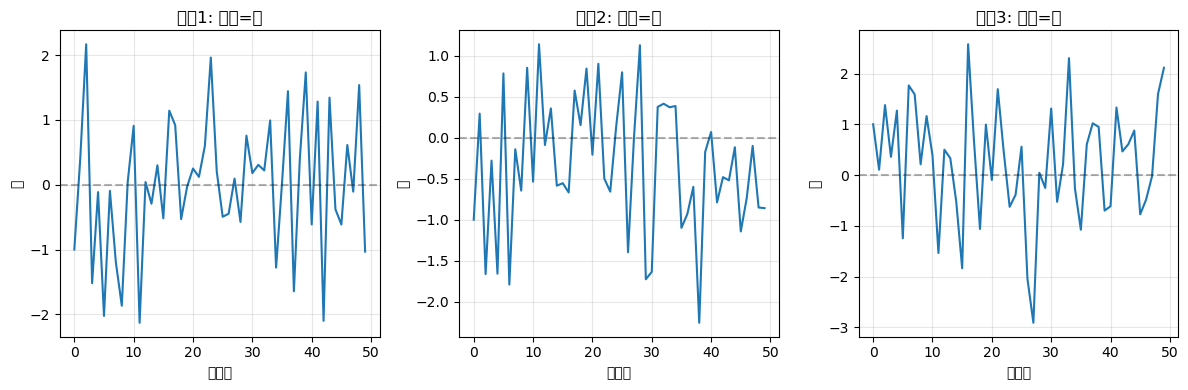

In [18]:
### 3. 梯度流对比：长序列依赖学习能力
###     让我们通过一个简单的长期依赖任务来测试三种架构：

def create_long_dependency_task(seq_len=100, batch_size=32):
    """
    创建长期依赖任务：
    序列开头有一个重要信号，序列末尾需要根据这个信号做预测
    """
    # 创建随机序列
    sequences = torch.randn(seq_len, batch_size, 1)
    
    # 在序列开头插入重要信号（0或1）
    signals = torch.randint(0, 2, (batch_size,)).float()
    sequences[0, :, 0] = signals * 2 - 1  # 转换为-1或1
    
    # 目标是在序列末尾预测开头的信号
    targets = signals
    
    return sequences, targets

# 创建长期依赖数据
long_seq, targets = create_long_dependency_task(seq_len=50, batch_size=64)
print("长期依赖任务:")
print("输入序列形状:", long_seq.shape)
print("目标形状:", targets.shape)
print("任务：根据序列第一个位置的信号预测类别")

# 可视化任务
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.plot(long_seq[:, i, 0].numpy())
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    plt.title(f'样本{i+1}: 信号={"正" if targets[i] == 1 else "负"}')
    plt.xlabel('时间步')
    plt.ylabel('值')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. 架构选择指南

基于以上分析，我们总结一下何时选择哪种架构：

### 5.1 性能特征对比表

| 特征 | RNN | LSTM | GRU |
|------|-----|------|-----|
| **参数数量** | 最少 (1x) | 最多 (4x) | 中等 (3x) |
| **计算速度** | 最快 | 最慢 | 中等 |
| **长期依赖** | 差 ❌ | 优秀 ✅ | 优秀 ✅ |
| **梯度稳定性** | 差 ❌ | 好 ✅ | 好 ✅ |
| **内存使用** | 少 | 多 | 中等 |
| **训练难度** | 容易梯度消失 | 稳定 | 稳定 |

### 5.2 选择建议

#### 选择 **RNN** 当：
- ✅ 序列很短（< 10步）
- ✅ 计算资源非常有限
- ✅ 不需要学习长期依赖
- ✅ 简单的序列模式识别

#### 选择 **LSTM** 当：
- ✅ 需要学习复杂的长期依赖（> 50步）
- ✅ 任务对准确性要求很高
- ✅ 有充足的计算资源和训练时间
- ✅ 序列中有复杂的上下文关系
- ✅ 自然语言处理任务

#### 选择 **GRU** 当：
- ✅ 需要平衡性能和效率
- ✅ 计算资源有限但需要长期依赖
- ✅ 数据量相对较小
- ✅ 快速原型开发
- ✅ 实时应用场景

### 5.3 实践经验

1. **从GRU开始**：如果不确定，先尝试GRU，它通常是性能/效率的好平衡点
2. **数据规模决定选择**：大数据集用LSTM，小数据集用GRU
3. **任务复杂度**：复杂任务（如机器翻译）用LSTM，简单任务用GRU
4. **实验对比**：最终选择应基于具体任务的实验结果

## 6. 常见问题与解答

### Q1: LSTM的门控机制真的有必要吗？
**A**: 是的！让我们看一个简化的证明：


In [19]:
# 演示梯度流的差异
def compute_gradient_norm(model, loss_fn, input_seq, target):
    """计算梯度范数"""
    model.zero_grad()
    output, _ = model(input_seq)
    loss = loss_fn(output[-1], target)
    loss.backward()
    
    total_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    return total_norm ** 0.5

# 创建测试数据
test_seq = torch.randn(20, 1, 10)  # 20步长序列
test_target = torch.randn(1, 50)   # 目标输出

# 创建简单模型用于测试
simple_rnn = nn.RNN(10, 50, 1)
simple_lstm = nn.LSTM(10, 50, 1)
simple_gru = nn.GRU(10, 50, 1)

loss_fn = nn.MSELoss()

# 计算梯度范数
rnn_grad_norm = compute_gradient_norm(simple_rnn, loss_fn, test_seq, test_target)
lstm_grad_norm = compute_gradient_norm(simple_lstm, loss_fn, test_seq, test_target)
gru_grad_norm = compute_gradient_norm(simple_gru, loss_fn, test_seq, test_target)

print("梯度范数对比（相同长度序列）:")
print(f"RNN梯度范数:  {rnn_grad_norm:.6f}")
print(f"LSTM梯度范数: {lstm_grad_norm:.6f}")
print(f"GRU梯度范数:  {gru_grad_norm:.6f}")

print("\n观察：LSTM和GRU的梯度范数通常更稳定，有利于训练")

梯度范数对比（相同长度序列）:
RNN梯度范数:  1.380481
LSTM梯度范数: 0.354787
GRU梯度范数:  0.664781

观察：LSTM和GRU的梯度范数通常更稳定，有利于训练


### Q2: 为什么LSTM有时候不如简单模型？
**A**: LSTM的优势需要在合适的场景才能体现：

LSTM可能表现不佳的情况:
1. 序列太短：门控机制的开销大于收益
2. 数据量太小：复杂模型容易过拟合
3. 任务太简单：不需要长期依赖学习
4. 特征工程不当：输入表示不合适
5. 超参数设置：学习率、层数等不合适

### Q3: 如何调试LSTM不收敛的问题？
**A**: 常见解决方案：

LSTM训练技巧:
* ✅ 梯度裁剪：防止梯度爆炸
    - `torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)`
* ✅ 合适的学习率：通常比CNN要小，尝试0.001-0.01
* ✅ 批次标准化：在LSTM后添加BatchNorm
* ✅ Dropout：防止过拟合，但不要过大（0.2-0.5）
* ✅ 权重初始化：使用Xavier或He初始化
* ✅ 学习率调度：使用余弦退火或阶梯式衰减

### Q4: LSTM的细胞状态C_t到底存储了什么？

细胞状态的内容分析:
* 长期记忆：重要的历史信息
* 上下文：句子或序列的整体语义
* 特征模式：学到的序列模式
* 任务相关信息：与预测目标相关的关键信息
* 可以理解为：压缩的序列摘要

## 思考练习

1. 理论思考
   - 为什么LSTM的遗忘门使用sigmoid而不是tanh？
   - GRU的更新门如何同时起到遗忘门和输入门的作用？

2. 实践练习
   - 尝试在不同长度的序列上比较三种架构
   - 实现一个简单的LSTM变体（如添加peephole连接）

3. 应用思考
   - 在你的具体问题领域，应该选择哪种架构？
   - 如何设计实验来验证架构选择的合理性？



## 参考资料

- **经典论文**：
  - [LSTM](http://www.bioinf.jku.at/publications/older/2604.pdf) - Hochreiter & Schmidhuber (1997)
  - [GRU](https://arxiv.org/abs/1406.1078) - Cho et al. (2014)
  - [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) - Chris Olah

- **实用资源**：
  - [PyTorch RNN Tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)
  - [Illustrated Guide to LSTM's and GRU's](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)


* [An Intuitive Explanation of LSTM](https://medium.com/@ottaviocalzone/an-intuitive-explanation-of-lstm-a035eb6ab42c)